In [187]:
from gs_quant.session import GsSession, Environment
from gs_quant.data import Dataset
import datetime
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GsSession.use(Environment.PROD, "d921d31700de4184bd36acf03c35dad6", "302268f93a20428022c72211f0db82dc3d2dc2b19bdd41024fe1e3182f28dce3")          # authenticate GS Session with credentials

In [294]:
ds = Dataset('COVID19_SUBDIVISION_DAILY')
df = ds.get_data(datetime.date(2019, 1, 12), datetime.date(2020, 8, 28))
df.head(2)

,subdivisionId,confirmedPerMillion,population,totalConfirmed,totalFatalities,totalRecovered,totalActive,updateTime,totalTested
date,,,,,,,,,
2020-01-21,US-MO,0.0,6137428.0,0.0,0.0,0.0,0.0,2020-03-30 12:46:09,NaN
2020-01-22,US-MO,0.0,6137428.0,0.0,0.0,0.0,0.0,2020-03-30 12:46:09,NaN


In [295]:
df['subdivisionId'].unique().tolist()[:7]

['US-MO', 'US-WV', 'US-OR', 'US-AZ', 'US-WI', 'US-SC', 'US-AK']

In [297]:
region = 'US-NY'
df_region = df[df['subdivisionId'] == region]

mask = df_region['totalConfirmed'].gt(0)
df_region = df_region[mask]
df_region.index = [x.date() for x in df_region.index]
df_region.head(10)

,subdivisionId,confirmedPerMillion,population,totalConfirmed,totalFatalities,totalRecovered,totalActive,updateTime,totalTested
2020-03-01,US-NY,0.051404,19453561.0,1.0,0.0,0.0,1.0,2020-05-26 12:33:17,NaN
2020-03-02,US-NY,0.051404,19453561.0,1.0,0.0,0.0,1.0,2020-05-26 12:33:17,NaN
2020-03-03,US-NY,0.102809,19453561.0,2.0,0.0,0.0,2.0,2020-05-26 12:33:17,NaN
2020-03-04,US-NY,0.565449,19453561.0,11.0,0.0,0.0,11.0,2020-05-26 12:33:17,54.0
2020-03-05,US-NY,1.130898,19453561.0,22.0,0.0,0.0,22.0,2020-05-26 12:33:17,98.0
2020-03-06,US-NY,2.261797,19453561.0,44.0,0.0,0.0,44.0,2020-05-26 12:33:17,125.0
2020-03-07,US-NY,3.906740,19453561.0,76.0,0.0,0.0,76.0,2020-05-26 12:33:17,168.0
2020-03-08,US-NY,5.397469,19453561.0,105.0,0.0,0.0,105.0,2020-05-26 12:33:17,197.0
2020-03-09,US-NY,7.299435,19453561.0,142.0,0.0,0.0,142.0,2020-05-26 12:33:17,234.0
2020-03-10,US-NY,8.892973,19453561.0,173.0,0.0,0.0,173.0,2020-05-26 12:33:17,265.0


In [298]:
del df_region['subdivisionId']
del df_region['updateTime']
del df_region['confirmedPerMillion']
df_region = df_region[['totalConfirmed','population','totalFatalities','totalRecovered','totalActive','totalTested']]
df_region.head(10)

,totalConfirmed,population,totalFatalities,totalRecovered,totalActive,totalTested
2020-03-01,1.0,19453561.0,0.0,0.0,1.0,NaN
2020-03-02,1.0,19453561.0,0.0,0.0,1.0,NaN
2020-03-03,2.0,19453561.0,0.0,0.0,2.0,NaN
2020-03-04,11.0,19453561.0,0.0,0.0,11.0,54.0
2020-03-05,22.0,19453561.0,0.0,0.0,22.0,98.0
2020-03-06,44.0,19453561.0,0.0,0.0,44.0,125.0
2020-03-07,76.0,19453561.0,0.0,0.0,76.0,168.0
2020-03-08,105.0,19453561.0,0.0,0.0,105.0,197.0
2020-03-09,142.0,19453561.0,0.0,0.0,142.0,234.0
2020-03-10,173.0,19453561.0,0.0,0.0,173.0,265.0


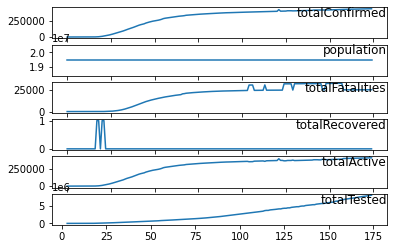

In [299]:
values = df_region.values
groups = [0, 1, 2, 3, 4, 5]

# plot each column
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_region.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [300]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = df_region.values
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
4   0.012270        0.0        0.0        0.0   0.000025   0.000000  0.018405
5   0.018405        0.0        0.0        0.0   0.000052   0.000005  0.024540
6   0.024540        0.0        0.0        0.0   0.000106   0.000009  0.030675
7   0.030675        0.0        0.0        0.0   0.000184   0.000014  0.036810
8   0.036810        0.0        0.0        0.0   0.000255   0.000018  0.042945


In [301]:
# split into train and test sets
values = reframed.values
n_train_days = 140
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140, 1, 6) (140,) (31, 1, 6) (31,)


Epoch 1/50
4/4 - 1s - loss: 0.3721 - val_loss: 0.7795
Epoch 2/50
4/4 - 0s - loss: 0.3385 - val_loss: 0.7267
Epoch 3/50
4/4 - 0s - loss: 0.3048 - val_loss: 0.6733
Epoch 4/50
4/4 - 0s - loss: 0.2713 - val_loss: 0.6191
Epoch 5/50
4/4 - 0s - loss: 0.2379 - val_loss: 0.5642
Epoch 6/50
4/4 - 0s - loss: 0.2044 - val_loss: 0.5082
Epoch 7/50
4/4 - 0s - loss: 0.1716 - val_loss: 0.4515
Epoch 8/50
4/4 - 0s - loss: 0.1393 - val_loss: 0.3936
Epoch 9/50
4/4 - 0s - loss: 0.1066 - val_loss: 0.3342
Epoch 10/50
4/4 - 0s - loss: 0.0783 - val_loss: 0.2777
Epoch 11/50
4/4 - 0s - loss: 0.0656 - val_loss: 0.2302
Epoch 12/50
4/4 - 0s - loss: 0.0606 - val_loss: 0.1915
Epoch 13/50
4/4 - 0s - loss: 0.0588 - val_loss: 0.1616
Epoch 14/50
4/4 - 0s - loss: 0.0590 - val_loss: 0.1414
Epoch 15/50
4/4 - 0s - loss: 0.0590 - val_loss: 0.1301
Epoch 16/50
4/4 - 0s - loss: 0.0578 - val_loss: 0.1252
Epoch 17/50
4/4 - 0s - loss: 0.0556 - val_loss: 0.1246
Epoch 18/50
4/4 - 0s - loss: 0.0527 - val_loss: 0.1263
Epoch 19/50
4/4 - 0

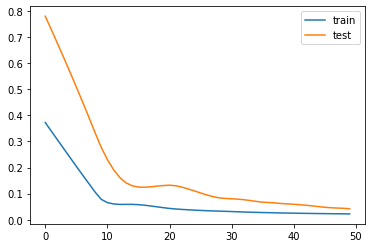

In [302]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [303]:
from pandas import concat
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.160


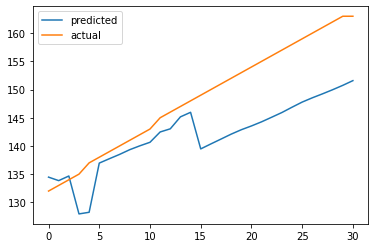

In [305]:
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()